In [13]:
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')
import glob

import xarray as xr
import dask
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import fileio
import spatial_selection
import general_utils

In [2]:
dask.config.set(temporary_directory='/g/data/xv83/dbi599')
cluster = LocalCluster()#n_workers=1, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34887 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [32]:
def plot_usa(ds, outfile=None):
    """USA plot"""
    
    fig = plt.figure(figsize=[12,5])
    map_proj = ccrs.LambertConformal(central_longitude=262.5, central_latitude=38.5, standard_parallels=[38.5, 38.5])
    h500_levels = np.arange(5000, 6300, 50)
    
    ax = fig.add_subplot(111, projection=map_proj)
    
    ds['tasmax'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.hot_r, vmin=10, vmax=50)
    
    lines = ds['h500'].plot.contour(ax=ax,
                                    transform=ccrs.PlateCarree(),
                                    levels=h500_levels,
                                    colors=['0.4'])
    ax.clabel(lines, colors=['0.4'], manual=False, inline=True)
        
    ax.plot(-122.31 + 360, 47.45, 'bo', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-140, -60, 20, 70])
    ax.gridlines(linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white')
    plt.show()

In [4]:
cafe_files = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-??[9,0,1,2]*/atmos_isobaric_daily.zarr.zip')
cafe_files.sort()

I think the unit conversion of tasmax needs to come after spatial subsetting...

In [5]:
ds_tasmax = fileio.open_mfzarr(cafe_files,
                               variables=['tasmax'],
                               metadata_file='../config/dataset_cafe_daily.yml',
                               spatial_coords=[47.45, -122.31 + 360])
# units={'tasmax': 'C'},

In [6]:
#ds_tasmax = ds_tasmax.compute()

In [7]:
argmax = ds_tasmax['tasmax'].argmax(dim=['ensemble', 'time'])

In [8]:
time_idx = int(argmax['time'].values)
print(f'Time index: {time_idx}')

Time index: 73506


In [9]:
ens_idx = int(argmax['ensemble'].values)
print(f'Ensemble index: {ens_idx}')

Ensemble index: 61


In [10]:
max_temp = float(ds_tasmax['tasmax'].isel({'ensemble': ens_idx , 'time': time_idx}).values)
print(f'Maximum temperature: {max_temp}C')

Maximum temperature: 319.24725341796875C


In [11]:
max_temp - 273.15

46.09725341796877

In [12]:
ds = fileio.open_mfzarr(cafe_files,
                        variables=['h500', 'tasmax'],
                        metadata_file='../config/dataset_cafe_daily.yml')
# units={'tasmax': 'C'},

In [14]:
ds_max = ds.isel({'ensemble': ens_idx, 'time': time_idx})

In [15]:
ds_max['tasmax'] = general_utils.convert_units(ds_max['tasmax'], 'C')

In [16]:
ds_max = ds_max.compute()

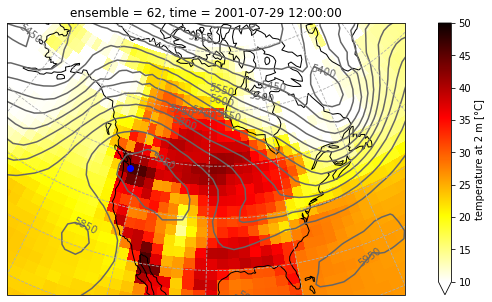

In [33]:
plot_usa(ds_max, outfile='/g/data/xv83/dbi599/seatac/seatac_hottest_day_cafe.pdf')

TODO: Same plot for JRA-55